In [1]:
#Import Packages

import numpy as np
from numpy import random as rd
from pykrx import stock
import scipy as sp
import pandas as pd
from scipy import optimize
import copy
import matplotlib.pyplot as plt

In [34]:
class DataManager:
    def __init__(self):
        self.data = None # pd.DF
        self.ret = None
        self.tickers = None
        self.ret = None
        self.N = None
        
    def setTickers(self, tickers):
        self.tickers = tickers
        self.N = len(self.tickers)
            
    def createRet(self):
        for i in range(1, self.data.shape[0]):
            self.ret.iloc[i] = self.data.iloc[i]/self.data.iloc[i-1]

    def loadData(self, srt, end):
        if type(srt) == str:
            srt = srt
        else:
            srt = str(srt)
        if type(end) == str:
            end = end
        else:
            end = str(end)
        raw_data = []
        N = self.N
        for i in range(N):
            raw_data.append(stock.get_market_ohlcv_by_date(srt, end, self.tickers[i])["종가"])
        self.data = pd.DataFrame(np.asarray(raw_data).T, columns = range(N), dtype=np.int32)
        self.ret = pd.DataFrame(np.nan, index=np.arange(self.data.shape[0]), columns=range(self.data.shape[1]))
        self.createRet()
        
    def get_ret(self):#맨 앞 nan 값은 제외하고전달
        return self.ret.iloc[1:]
    

In [139]:
a123=np.asarray([1,2,3,4])
1/a123

array([1.        , 0.5       , 0.33333333, 0.25      ])

In [142]:
(1/a123).sum()

2.083333333333333

In [166]:
class Optima:
    def __init__(self):
        self.var_cov_mat = None
        self.rf = 0.015
        self.N = None
        self.data = None
        self.tp = None # time Point
        self.windowLength = None
        
    def loadData(self, data): #이때 받아오는 데이터는 ret이다.
        self.data = data
        self.N = data.shape[1]
        self.var_cov_mat = np.identity(self.N)#var cov mat init
    
    def gen_var_cov_mat(self):
        ret_tp = self.data.iloc[self.tp - self.windowLength : self.tp]
        for i in range(0, self.N):
            for j in range(0, self.N):
                self.var_cov_mat[i][j] = np.cov(ret_tp.iloc[1:,i], ret_tp.iloc[1:,j])[0,1]
    
    def setWindowLength(self, time):
        self.windowLength = time
    
    def setTimePoint(self, tp):
        self.tp = tp

###################################################################################################
###################################################################################################

    def eq_constraint(self, w):
        summation = 0
        for i in w:
            summation += i
            
        return summation - 1
    
    def flarray_MaxSharp(self, w): #수익률도 전체 데이터가 아닌 특정기간의 수익률로 바꿔줘야함!!!!!
        ret_exd = np.cumprod(self.data.iloc[self.tp - self.windowLength : self.tp]) - self.rf
        return -(np.dot(np.transpose(ret_exd.iloc[-1]), w) / (np.dot(np.dot(np.transpose(w), self.var_cov_mat), w))**(1/2))

    def Max_Sharp(self):
        return sp.optimize.fmin_slsqp(self.flarray_MaxSharp, [1/self.N for i in range(self.N)], bounds=[(0,1) for i in range(self.N)], eqcons=[self.eq_constraint])
    
    
    def Equal_Weight(self):
        return [1/self.N for i in range(self.N)]
    
    def Inverse_Volatility(self):
        self.gen_var_cov_mat()
        vol = []
        for i in range(N):
            vol.append(self.var_cov_mat[i][i])
        inv_vol = 1/np.asarray(vol)
        sum_inv_vol = inv_vol.sum()
        return inv_vol/sum_inv_vol
    
#####
    def flarray_ERC(self, w):
        summation = 0
        risk = np.dot(np.dot(np.transpose(w), self.var_cov_mat), w) # sigma _ w
        N = len(w)
        for wi, i in zip(w, range(0,N)):
            summation += (wi - risk/(N* np.array(np.dot(self.var_cov_mat, w)[i])))**2
        return summation
    
    def ERC(self):
        return sp.optimize.fmin_slsqp(self.flarray_ERC, [1/self.N for i in range(self.N)], bounds=[(0,1) for i in range(self.N)], eqcons=[self.eq_constraint])
    
    def flarray_MinVariance(self, w):
        risk = np.dot(np.dot(np.transpose(w), self.var_cov_mat), w) # sigma _ w
        return risk
    
    def Min_Variance(self):
        return sp.optimize.fmin_slsqp(self.flarray_MinVaraince, [1/self.N for i in range(self.N)], bounds=[(0,1) for i in range(self.N)], eqcons=[self.eq_constraint])

###################################################################################################
###################################################################################################
    
    def w(self, method='ERC'):# EW, IV, ERC , MV , MS
        
        if method=='MS':
            self.gen_var_cov_mat()
            return self.Max_Sharp()
        
        elif method=='EW':
            return self.Equal_Weight()
        
        elif method=='IV':
            return self.Inverse_Volatility()
        
        elif method=='MV':
            self.gen_var_cov_mat()
            return self.Min_Variance()
        
        elif method=='ERC':
            self.gen_var_cov_mat()
            return self.ERC()


In [167]:
tickers = ["002810", "003920", "004380", "011280", "016580", "007340", "000370", "001510", "033270", "004710", "001500"]

optima = Optima()
dm = DataManager()

dm.setTickers(tickers)
dm.loadData(20150101, 20191231)

optima.loadData(dm.get_ret())

optima.setWindowLength(30)
optima.setTimePoint(60)

In [170]:
optima.var_cov_mat

array([[ 4.50205773e-04,  8.78178967e-05,  1.60966988e-05,
         2.41813839e-04,  2.02378309e-04,  1.02029835e-04,
         1.10624722e-05,  6.86710224e-05, -1.34482530e-04,
        -2.99924383e-05,  6.35322907e-08],
       [ 8.78178967e-05,  2.65922129e-04,  2.40812370e-05,
         2.17888311e-05,  2.00021160e-04,  1.40146979e-04,
         4.55488671e-06,  6.96772125e-05, -5.24857375e-05,
        -8.19026765e-05,  4.68866330e-05],
       [ 1.60966988e-05,  2.40812370e-05,  1.32876898e-04,
        -2.78033035e-05,  1.06781024e-04,  2.31043565e-05,
         2.24191975e-05,  4.38124056e-05,  5.95140950e-05,
        -7.45967290e-05,  4.43987743e-05],
       [ 2.41813839e-04,  2.17888311e-05, -2.78033035e-05,
         3.45099860e-04,  2.11383529e-04,  5.91257058e-05,
         5.55275853e-06, -4.75879607e-06,  4.44272686e-05,
        -1.24659346e-04, -6.08120595e-05],
       [ 2.02378309e-04,  2.00021160e-04,  1.06781024e-04,
         2.11383529e-04,  1.06504549e-03,  1.22898849e-04,
  

In [169]:
optima.w('ERC')

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.9891519154859307e-07
            Iterations: 12
            Function evaluations: 164
            Gradient evaluations: 12


array([0.07867106, 0.10864078, 0.16170499, 0.10362179, 0.03686924,
       0.08002913, 0.12038133, 0.05041618, 0.11729132, 0.08525148,
       0.0571227 ])

In [124]:
pd.DataFrame((result for i in range(10)))

,0,1,2,3
0,0.230405,0.513425,0.127093,0.129077
1,0.230405,0.513425,0.127093,0.129077
2,0.230405,0.513425,0.127093,0.129077
3,0.230405,0.513425,0.127093,0.129077
4,0.230405,0.513425,0.127093,0.129077
5,0.230405,0.513425,0.127093,0.129077
6,0.230405,0.513425,0.127093,0.129077
7,0.230405,0.513425,0.127093,0.129077
8,0.230405,0.513425,0.127093,0.129077
9,0.230405,0.513425,0.127093,0.129077


In [251]:
kkk

,0,1,2,3
0,0.188119,0.690803,0.014005,0.107073
1,0.188119,0.690803,0.014005,0.107073
2,0.188119,0.690803,0.014005,0.107073
3,0.188119,0.690803,0.014005,0.107073
4,0.188119,0.690803,0.014005,0.107073


In [9]:
optima.data.shape
#optima.w()

(245, 4)

In [274]:
wwwww=pd.DataFrame(([1 for i in range(4)] for i in range(rebal.shape[0])))
optima.setTimePoint(200)
aaaa = optima.w()
wwwww.iloc[1:20] = pd.DataFrame((aaaa for i in range(25)))
wwwww.iloc[10:20] = pd.DataFrame((result for i in range(10)), index=range(10,20))
wwwww.head(30)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -183.4815566988701
            Iterations: 6
            Function evaluations: 40
            Gradient evaluations: 6


,0,1,2,3
0,1.000000,1.000000,1.000000,1.000000e+00
1,0.496817,0.480102,0.023081,2.696273e-13
2,0.496817,0.480102,0.023081,2.696273e-13
3,0.496817,0.480102,0.023081,2.696273e-13
4,0.496817,0.480102,0.023081,2.696273e-13
5,0.496817,0.480102,0.023081,2.696273e-13
6,0.496817,0.480102,0.023081,2.696273e-13
7,0.496817,0.480102,0.023081,2.696273e-13
8,0.496817,0.480102,0.023081,2.696273e-13
9,0.496817,0.480102,0.023081,2.696273e-13


In [5]:
w_init=[1/4,1/4,1/4,1/4]

In [63]:
ww=pd.DataFrame(([1 for i in range(4)] for i in range(rebal.shape[0])))
fr = 5
optima.setWindowLength(fr)
ww.iloc[0*fr : 1*fr] = pd.DataFrame((w_init for i in range(fr)))
print('hi')
for i in range((rebal.shape[0]//fr)):
    optima.setTimePoint(200)
    #result = optima.w()
    print(f"-------------{result}---------")
    if i == (rebal.shape[0]//fr)-1 :#마지막일때
#        optima.setTimePoint(-1)
        result = optima.w()
        print(result)
        #ww.iloc[(rebal.shape[0]//fr)*fr : ] = pd.DataFrame((result for i in range(fr)), index=range((rebal.shape[0]//fr)*fr, rebal.shape[0]))
    else:
        ww.iloc[(i+1)*fr : (i+2)*fr] = pd.DataFrame((result for i in range(fr)), index=range((i+1)*fr, (i+2)*fr))
    #    pass
ww.head(30)
#ww.tail(30)

hi
-------------[0.05398018 0.81566648 0.         0.13035348]---------
-------------[0.05398018 0.81566648 0.         0.13035348]---------
-------------[0.05398018 0.81566648 0.         0.13035348]---------
-------------[0.05398018 0.81566648 0.         0.13035348]---------
-------------[0.05398018 0.81566648 0.         0.13035348]---------
-------------[0.05398018 0.81566648 0.         0.13035348]---------
-------------[0.05398018 0.81566648 0.         0.13035348]---------
-------------[0.05398018 0.81566648 0.         0.13035348]---------
-------------[0.05398018 0.81566648 0.         0.13035348]---------
-------------[0.05398018 0.81566648 0.         0.13035348]---------
-------------[0.05398018 0.81566648 0.         0.13035348]---------
-------------[0.05398018 0.81566648 0.         0.13035348]---------
-------------[0.05398018 0.81566648 0.         0.13035348]---------
-------------[0.05398018 0.81566648 0.         0.13035348]---------
-------------[0.05398018 0.81566648 0.       

,0,1,2,3
0,0.25000,0.250000,0.25,0.250000
1,0.25000,0.250000,0.25,0.250000
2,0.25000,0.250000,0.25,0.250000
3,0.25000,0.250000,0.25,0.250000
4,0.25000,0.250000,0.25,0.250000
5,0.05398,0.815666,0.00,0.130353
6,0.05398,0.815666,0.00,0.130353
7,0.05398,0.815666,0.00,0.130353
8,0.05398,0.815666,0.00,0.130353
9,0.05398,0.815666,0.00,0.130353


In [68]:
dict1 = {'freq':['ret', 'vol', 'sharp', 'mdd']}

In [70]:
len(dict1.keys())

1

In [126]:
class PerformanceAnalyzer:
    def __init__(self,data , optima):
        self.freq = None
        self.data = data
        self.optima = optima
        self.analyzedPerformances = dict()
        
        #for Test
        self.ww = None
        self.cump = None
        self.scalars = None
        
    def analyze(self, freq):
        #fr 지정해주기.
        fr = freq
        self.optima.setTimePoint(fr)

        
        rebal = self.data
        #가져온 데이터를 앞 fr과 나머지 뒷부분으로 나누어준다.
        w_init_rebal = rebal.iloc[0:fr]
        rebal = rebal.iloc[fr:]
        dataLength = rebal.shape[0]
        num_columns = rebal.shape[1]
        ##중요
        rebal.index=range(dataLength)
        
        #w init 구하기
        self.optima.setWindowLength(fr)
        w_init = self.optima.w()
        
        scalar = pd.DataFrame(index=range(0,dataLength//fr+1))
        scalar['k'] = 1
        
        #일단 w값부터 모두 구하자.
        ww=pd.DataFrame(([999 for i in range(num_columns)] for i in range(dataLength)))
        
        #ww에 초기값 입력
        ww.iloc[0*fr : 1*fr] = pd.DataFrame((w_init for i in range(fr)))
        
        for i in range(dataLength//fr):
            self.optima.setTimePoint((i+1)*fr)
            if i == (dataLength//fr)-1 :#for문 마지막 이터 일때
                result = self.optima.w()
                ww.iloc[(dataLength//fr)*fr : ] = pd.DataFrame((result for i in range(dataLength%fr)), index = range((dataLength//fr)*fr, dataLength))
            else:
                result = self.optima.w()
                ww.iloc[(i+1)*fr:(i+2)*fr] = pd.DataFrame((result for i in range(fr)), index = range((i+1)*fr , (i+2)*fr))

            
        cumprod_DF = copy.deepcopy(rebal)
        
        #리밸런싱 기간씩 끊어서 cumprod를 구해줌.
        for i in range((rebal.shape[0]//fr)):#fr = 4 , range(0,2)
            cumprod_DF.iloc[i*fr:(i+1)*fr] = rebal.iloc[i*fr :(i+1)*fr].cumprod()
            if i != 0:#스칼라도 똑같이 해주는데, 첫번째 이터레이션에서는 초기값 1로 고정. 따라서 i==0일때 상위 포문 넘어감.
                #이것도 실제로는 동일비중이 아니라, 특정 w벡터로 나눠줘야함.
                scalar['k'].iloc[i] = cumprod_DF.iloc[i*fr - 1].sum()/cumprod_DF.shape[1]

        if rebal.shape[0]%fr != 0:
            mok = rebal.shape[0]//fr
            scalar['k'].iloc[-1 ] = cumprod_DF.iloc[(mok)*fr -1 ].sum()/cumprod_DF.shape[1]
            cumprod_DF.iloc[mok*fr : ] = rebal.iloc[mok*fr:].cumprod()
        ############
        ############
        scalars = pd.DataFrame(index=range(0,rebal.shape[0]), columns=range(0,rebal.shape[1]))
        for i in range(rebal.shape[0]//fr):
            scalars[0].iloc[i*fr : i*fr+fr] = scalar.cumprod().iloc[i][0]#float(scalar.iloc[i]) * float(scalar.iloc[i-1])
            if i == 0:
                scalars[0].iloc[i*fr : i*fr+fr] = 1

        if rebal.shape[0]%fr != 0:#32개 중 마지막 2개에 대 한 처리
            mok = rebal.shape[0]//fr
            scalars[0].iloc[(mok)*fr : ] = scalar.cumprod().iloc[-1][0]#float(scalar.iloc[-1])*float(scalar.iloc[-2])

        for i in range(1,rebal.shape[1]):
            scalars[i] = scalars[i-1]


        #print((ww * cumprod_DF * scalars).sum(axis=1))
        self.ww = ww
        self.cump = cumprod_DF
        self.scalars = scalars
        
        self.analyzedPerformances[-1] = [rebal.cumprod().sum(axis=1)/rebal.shape[1]]
        self.analyzedPerformances[fr] = [(ww*cumprod_DF * scalars).sum(axis=1)]

        plt.figure()
        plt.plot((ww * cumprod_DF * scalars).sum(axis=1), c='g')
        #plt.plot((ww*cumprod_DF).sum(axis=1))
        #리밸런싱을 안하면 cumprod_DF를 쓰는게 아니라 그냥 cumprod(testdf)하면 되는 거였음.
        plt.plot(rebal.cumprod().sum(axis=1)/rebal.shape[1], c='gray')
        plt.show()
        #시각화 대신 데이터를 인스턴스에 저장
        
    def visualize(self):
        benchmark = self.analyzedPerformances[-1][0]
        keys = list(self.analyzedPerformances) # keys : [-1, 30, 60, 90]
        maxplot = int(np.ceil(np.sqrt(len(self.analyzedPerformances.keys()) -1))) # 4-1 :3개 루트 반올림.
        
        for i in range(maxplot**2):
            #if i len(key)
            pltkey = 110*maxplot + 1 + i
            plt.subplot(pltkey)
            try:    
                plt.title(keys[i+1])
                plt.plot(self.analyzedPerformances[keys[i+1]][0], c='g')
                plt.plot(benchmark, c='gray')
            except IndexError:
                pass
    
    def visualize_1plot(self):
        plt.figure()
        for key in self.analyzedPerformances:
            if key == -1:
                plt.plot(self.analyzedPerformances[key][0], c='gray')
            plt.plot(self.analyzedPerformances[key][0])
        plt.show()
            
pa = PerformanceAnalyzer(dm.get_ret(), optima)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -150.19800495645575
            Iterations: 22
            Function evaluations: 305
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -150.19800495645575
            Iterations: 22
            Function evaluations: 305
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -163.5878664114092
            Iterations: 20
            Function evaluations: 283
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -128.35933331943247
            Iterations: 12
            Function evaluations: 165
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -120.9747498029608
            Iterations: 15
            

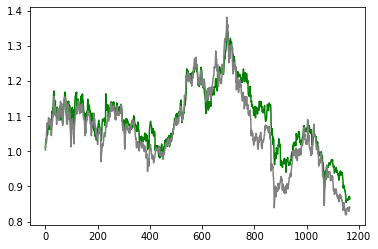

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -164.6066328604764
            Iterations: 20
            Function evaluations: 285
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -164.6066328604764
            Iterations: 20
            Function evaluations: 285
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -121.5737158380588
            Iterations: 14
            Function evaluations: 193
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -118.07123865984964
            Iterations: 17
            Function evaluations: 234
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -143.36811716628048
            Iterations: 17
            F

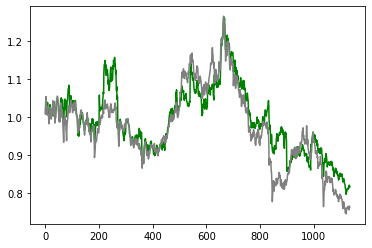

In [124]:

pa.analyze(60)
pa.analyze(90)

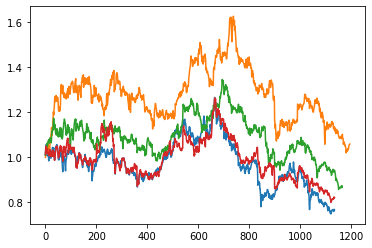

In [125]:
pa.visualize_1plot()

In [132]:
pd.DataFrame(np.nan, index=['ret', 'vol' , 'mdd' , 'sharp', 'divers.ratio'], columns =[10,20,30,60,90,120])

,10,20,30,60,90,120
ret,NaN,NaN,NaN,NaN,NaN,NaN
vol,NaN,NaN,NaN,NaN,NaN,NaN
mdd,NaN,NaN,NaN,NaN,NaN,NaN
sharp,NaN,NaN,NaN,NaN,NaN,NaN
divers.ratio,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
dict123 = {'a':123, 2:234, 3:345}
for i in range(3):
    print(dict123.keys())

dict_keys(['a', 2, 3])
dict_keys(['a', 2, 3])
dict_keys(['a', 2, 3])


In [83]:
list(dict123)

['a', 2, 3]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -172.70386134838938
            Iterations: 20
            Function evaluations: 281
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -172.70386134838938
            Iterations: 20
            Function evaluations: 281
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -162.21664825084903
            Iterations: 19
            Function evaluations: 263
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -206.63036739648962
            Iterations: 25
            Function evaluations: 354
            Gradient evaluations: 25
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -147.99119852189511
            Iterations: 22
          

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -272.2985012471623
            Iterations: 19
            Function evaluations: 267
            Gradient evaluations: 19


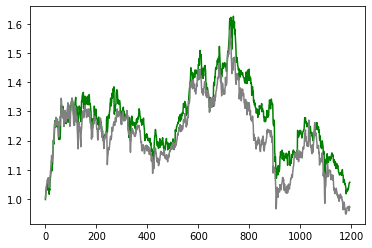

In [123]:
pa.analyze(30)

In [44]:
pa.scalars

,0,1,2,3
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1
...,...,...,...,...
210,0.8923,0.8923,0.8923,0.8923
211,0.8923,0.8923,0.8923,0.8923
212,0.8923,0.8923,0.8923,0.8923
213,0.8923,0.8923,0.8923,0.8923


In [48]:
pa.cump

,0,1,2,3
31,0.974762,1.000000,0.960573,1.001089
32,0.996829,0.998410,0.946237,0.989107
33,1.012619,0.992051,0.956989,1.030501
34,1.009448,0.995231,0.942652,1.019608
35,0.990552,1.003180,0.985663,1.043573
...,...,...,...,...
241,1.009187,1.013111,0.995671,0.990408
242,1.018373,1.039333,0.982684,0.983213
243,1.021457,1.032181,0.995671,1.028777
244,1.031093,1.027414,1.012987,1.044365


In [106]:
pa.ww

,0,1,2,3
0,5.293821e-13,1.000000e+00,2.800732e-12,3.518380e-12
1,5.293821e-13,1.000000e+00,2.800732e-12,3.518380e-12
2,5.293821e-13,1.000000e+00,2.800732e-12,3.518380e-12
3,5.293821e-13,1.000000e+00,2.800732e-12,3.518380e-12
4,5.293821e-13,1.000000e+00,2.800732e-12,3.518380e-12
...,...,...,...,...
91,8.645643e-15,8.505877e-14,4.833535e-01,5.166467e-01
92,8.645643e-15,8.505877e-14,4.833535e-01,5.166467e-01
93,8.645643e-15,8.505877e-14,4.833535e-01,5.166467e-01
94,8.645643e-15,8.505877e-14,4.833535e-01,5.166467e-01


In [90]:
pa.cump

,002810,003920,004380,011280
6,0.993782,0.992661,1.009091,1.001634
7,1.018784,0.992661,0.986364,1.026144
8,1.009425,0.992661,0.990909,1.151961
9,1.018784,1.001835,0.990909,1.165033
10,1.006283,0.988991,0.977273,1.151961
...,...,...,...,...
97,1.028143,1.004728,0.991379,0.998791
98,1.037502,1.030733,0.978448,0.991536
99,1.040644,1.023641,0.991379,1.037485
100,1.050461,1.018913,1.008621,1.053204


In [94]:
pa.scalars

,0,1,2,3
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1
...,...,...,...,...
91,0.871579,0.871579,0.871579,0.871579
92,0.871579,0.871579,0.871579,0.871579
93,0.871579,0.871579,0.871579,0.871579
94,0.871579,0.871579,0.871579,0.871579


In [54]:
pa.scalars[0].values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1.0987268521076603, 1.0987268521076603, 1.0987268521076603,
       1.0987268521076603, 1.0987268521076603, 1.0987268521076603,
       1.0987268521076603, 1.0987268521076603, 1.0987268521076603,
       1.0987268521076603, 1.0987268521076603, 1.0987268521076603,
       1.0987268521076603, 1.0987268521076603, 1.0987268521076603,
       1.0987268521076603, 1.0987268521076603, 1.0987268521076603,
       1.0987268521076603, 1.0987268521076603, 1.1705384422688412,
       1.1705384422688412, 1.1705384422688412, 1.1705384422688412,
       1.1705384422688412, 1.1705384422688412, 1.1705384422688412,
       1.1705384422688412, 1.1705384422688412, 1.1705384422688412,
       1.1705384422688412, 1.1705384422688412, 1.1705384422688412,
       1.1705384422688412, 1.1705384422688412, 1.1705384422688412,
       1.1705384422688412, 1.1705384422688412, 1.1705384422688412,
       1.1705384422688412, 1.183811582709743, 1.18381158270974

In [8]:
rebal = pd.DataFrame(([1+np.random.randint(-10,13)*0.0051 for i in range(5)] for i in range(333)))


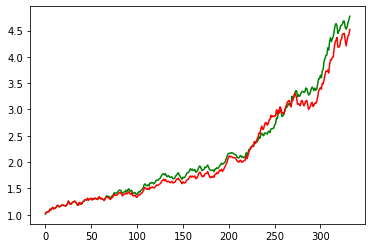

In [72]:
fr = 60
scalar = pd.DataFrame(index=range(0,rebal.shape[0]//fr+1))
scalar['k'] = 1

cumprod_DF = copy.deepcopy(rebal)

for i in range((rebal.shape[0]//fr)):#fr = 4 , range(0,2)
    cumprod_DF.iloc[i*fr:(i+1)*fr] = rebal.iloc[i*fr :(i+1)*fr].cumprod()
    if i != 0:
        #이것도 실제로는 동일비중이 아니라, 특정 w벡터로 나눠줘야함.
        scalar['k'].iloc[i] = cumprod_DF.iloc[i*fr - 1].sum()/cumprod_DF.shape[1]

if rebal.shape[0]%fr != 0:
    mok = rebal.shape[0]//fr
    scalar['k'].iloc[-1 ] = cumprod_DF.iloc[(mok)*fr -1 ].sum()/cumprod_DF.shape[1]
    cumprod_DF.iloc[mok*fr : ] = rebal.iloc[mok*fr:].cumprod()
############
############
scalars = pd.DataFrame(index=range(0,rebal.shape[0]), columns=range(0,rebal.shape[1]))
for i in range(rebal.shape[0]//fr):
    scalars[0].iloc[i*fr : i*fr+fr] = scalar.cumprod().iloc[i][0]#float(scalar.iloc[i]) * float(scalar.iloc[i-1])
    if i == 0:
        scalars[0].iloc[i*fr : i*fr+fr] = 1

if rebal.shape[0]%fr != 0:#32개 중 마지막 2개에 대 한 처리
    mok = rebal.shape[0]//fr
    scalars[0].iloc[(mok)*fr : ] = scalar.cumprod().iloc[-1][0]#float(scalar.iloc[-1])*float(scalar.iloc[-2])

for i in range(1,rebal.shape[1]):
    scalars[i] = scalars[i-1]

ww=pd.DataFrame(([1/rebal.shape[1] for i in range(rebal.shape[1])] for i in range(rebal.shape[0])))

(ww * cumprod_DF * scalars).sum(axis=1)

plt.figure()
plt.plot((ww * cumprod_DF * scalars).sum(axis=1), c='g')
#plt.plot((ww*cumprod_DF).sum(axis=1))
#리밸런싱을 안하면 cumprod_DF를 쓰는게 아니라 그냥 cumprod(testdf)하면 되는 거였음.
plt.plot(rebal.cumprod().sum(axis=1)/rebal.shape[1], c='r')
plt.show()

In [71]:
scalar#.cumprod()

,k
0,1.000000
1,1.334647
2,1.198567
3,1.165147
4,1.369831
5,1.404607


,0,1,2,3,4
0,1,1,1,1,1
1,1,1,1,1,1
2,1,1,1,1,1
3,1,1,1,1,1
4,1,1,1,1,1
5,1,1,1,1,1
6,1,1,1,1,1
7,1,1,1,1,1
8,1,1,1,1,1
9,1,1,1,1,1


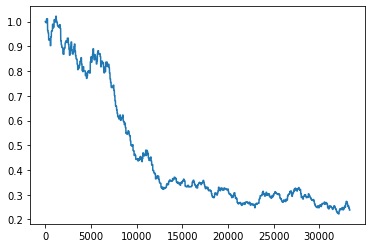

In [46]:
plt.figure()
plt.plot(scalars[0])
plt.show()

In [430]:
(ww * cumprod_DF * scalars).sum(axis=1).iloc[-1]

4.9807235967387635

In [434]:
rebal.cumprod().sum(axis=1).iloc[-1]/6

4.909872591776103

In [5]:
mdd = pd.DataFrame(([rd.randint(-5, 8)*0.01 + 1 for i in range(100)]))
#mdd = pd.DataFrame([1,2,3,4,2,3,4,5,1,2,6])
mdd = mdd.cumprod()

In [7]:
newhigh = copy.deepcopy(mdd)
for i in range(1, mdd.shape[0]):
    newhigh.iloc[i] = max(mdd.iloc[i][0], mdd.iloc[0:i].max()[0])

In [8]:
mdd.iloc[0:3].max()[0]

0.9875250000000001

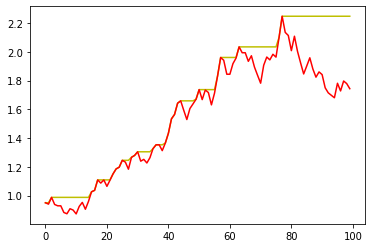

In [9]:
plt.figure()
plt.plot(newhigh, c='y')
plt.plot(mdd, c='r')
plt.show()

In [10]:
maxdrawdown = - newhigh + mdd

0   -0.567247
dtype: float64


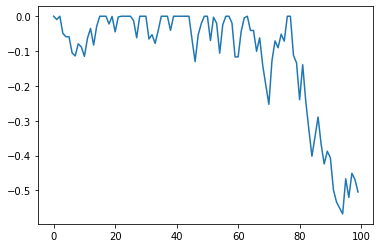

In [13]:
plt.plot(maxdrawdown)
print(maxdrawdown.min())

In [492]:
scalars

,0,1,2,3
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1
...,...,...,...,...
484,0.924381,0.924381,0.924381,0.924381
485,0.924381,0.924381,0.924381,0.924381
486,0.924381,0.924381,0.924381,0.924381
487,0.924381,0.924381,0.924381,0.924381


In [480]:
cumprod_DF

,0,1,2,3
1,0.967015,0.995733,1.161215,0.998012
2,0.964246,0.992888,1.133178,0.994036
3,0.950462,0.984353,1.144860,0.998012
4,0.934031,0.974395,1.088785,0.994036
5,0.939508,0.970128,1.119159,0.990060
...,...,...,...,...
485,1.034576,1.005917,1.008772,0.969484
486,1.043994,1.031953,0.995614,0.962441
487,1.047155,1.024852,1.008772,1.007042
488,1.057034,1.020118,1.026316,1.022300


# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#

In [39]:
testdf.iloc[0:2].sum(axis = 1)

0    6.03
1    6.11
dtype: float64

In [222]:
freq = 10
w = [1/5, 1/5, 1/5, 1/5, 1/5]

In [239]:
rebal.shape[0]%freq

8

In [243]:
a = np.asarray([1,2,3])
b = np.asarray([1,2,3])
a*b

array([1, 4, 9])

In [242]:
for i in range((rebal.shape[0]//freq)):
    df = rebal.iloc[i*freq :(i+1)*freq]
    print(df)
    
if rebal.shape[0]%freq != 0:
    print(rebal.iloc[-(rebal.shape[0]%freq):])


      0     1     2     3     4     5
0  1.02  0.93  0.95  0.99  1.02  0.95
1  1.05  0.94  1.05  1.11  1.11  1.03
2  0.97  1.05  0.98  1.02  0.99  1.04
3  0.90  0.99  1.09  1.11  1.08  0.97
4  0.96  1.03  0.97  1.01  0.99  1.10
5  0.95  1.08  0.94  0.90  0.90  1.00
6  0.92  1.07  0.97  1.08  1.06  0.99
7  0.99  1.09  1.10  1.07  0.94  1.11
8  0.99  1.01  1.07  0.97  0.98  0.97
9  1.01  1.03  1.08  1.06  1.04  0.97
       0     1     2     3     4     5
10  1.09  0.93  1.03  1.07  1.01  0.94
11  0.97  1.04  1.02  0.91  0.91  1.04
12  0.93  1.09  0.93  0.91  0.97  1.00
13  1.04  0.97  1.00  1.06  1.03  1.05
14  1.01  0.90  0.98  1.01  1.02  0.91
15  0.99  0.90  1.05  1.08  1.01  1.08
16  1.04  0.91  1.04  0.98  0.96  0.93
17  1.00  1.07  1.10  0.93  0.96  0.94
18  1.11  1.10  0.97  0.98  0.92  0.91
19  1.06  1.02  0.92  1.03  1.07  1.09
       0     1     2     3     4     5
20  0.93  0.98  1.00  1.01  1.07  0.90
21  1.11  0.95  1.08  0.95  1.11  0.94
22  0.93  0.95  0.96  0.98  1.00  1.

In [120]:
rebal.iloc[5:10].cumprod()

,0,1,2,3,4,5
5,1.060000,1.100000,0.910000,1.04000,0.960000,1.000000
6,1.134200,1.133000,0.819000,0.98800,0.892800,0.940000
7,1.100174,1.178320,0.794430,1.07692,0.964224,0.921200
8,1.045165,1.225453,0.714987,1.07692,0.896728,0.985684
9,1.076520,1.127417,0.779336,1.07692,0.941565,0.965970


In [119]:
rebal.iloc[1:5].cumprod()

,0,1,2,3,4,5
1,1.070000,0.900000,0.900000,1.020000,1.030000,0.900000
2,0.984400,0.882000,0.810000,0.948600,0.999100,0.819000
3,1.092684,0.943740,0.801900,1.033974,1.059046,0.761670
4,1.212879,0.972052,0.745767,0.982275,1.016684,0.845454


In [121]:
rebal.head(11)

,0,1,2,3,4,5
0,1.00,0.94,0.94,1.02,0.94,1.05
1,1.02,1.02,1.02,1.04,1.07,0.97
2,1.08,0.99,0.96,1.03,1.02,1.05
3,1.09,0.91,1.01,0.94,0.95,0.96
4,1.05,0.97,0.92,0.99,1.09,1.04
5,1.11,1.05,0.93,1.02,1.00,1.09
6,0.92,1.03,1.11,1.04,1.09,1.07
7,1.05,1.05,0.91,1.09,1.08,0.93
8,0.90,1.07,0.91,0.91,1.09,0.93
9,0.97,1.10,1.00,0.94,0.97,1.11


In [34]:
pd.DataFrame.cumsum(rebal.cumprod().iloc[-1])[-1:]/5

5    1.617605
Name: 111, dtype: float64

In [134]:
rebal.cumprod().iloc[-1]

0    3.541576
1    0.591426
2    0.583374
3    1.051113
4    4.484368
5    1.611752
Name: 99, dtype: float64

In [205]:
aaaa = pd.DataFrame(([1,2,3],[2,2,5],[3,2,2]))

In [206]:
aaaa

,0,1,2
0,1,2,3
1,2,2,5
2,3,2,2


In [207]:
aaaa.cumprod()

,0,1,2
0,1,2,3
1,2,4,15
2,6,8,30


In [208]:
aaaa.cumprod().sum(axis=1)

0     6
1    21
2    44
dtype: int64

In [211]:
aaaa.sum(axis=1)

0    6
1    9
2    7
dtype: int64